In [2]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [84]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import plot_boxplot

from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations, get_n_updates_customized

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

# set_style()

In [64]:
def remove_ourliers(result_df):
    q1 = result_df['normalized_error'].quantile(0.25)
    q3 = result_df['normalized_error'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    result_df_no_outliers = result_df[(result_df['normalized_error'] >= lower_bound) & (result_df['normalized_error'] <= upper_bound)].copy()
    return result_df_no_outliers

## Lineitem Scale

In [59]:
scale_factors = 4**np.arange(4) * 0.03125
n_elements = ['187 k', '750 k', '3 M', '12 M']

results = []
for sf, n in zip(scale_factors, n_elements):
    result_df = pd.read_csv(f"../results/tpch/scale/tpch_random_results_2_{sf}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/scale/tpch_random_results_{sf}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df['approach'] = n
    results.append(result_df)

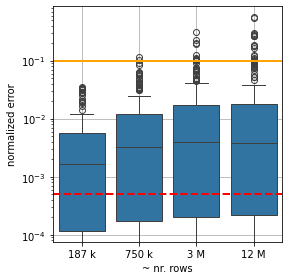

In [60]:
custom_palette = {
    '187 k': 'tab:blue',
    '750 k': 'tab:blue',
    '3 M': 'tab:blue',
    '12 M': 'tab:blue',
}
plot_boxplot(results, target=0.0005, log_scale=True, x_label='~ nr. rows', figsize=(4, 4), palette=custom_palette)

In [65]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

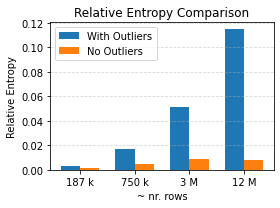

In [73]:
labels = n_elements
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width, label='No Outliers')

ax.set_ylabel('Relative Entropy')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
ax.set_title('Relative Entropy Comparison')

plt.tight_layout()
plt.show()

In [85]:
rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

error_eps = rel_eps / region_updates_tpch
sizes = []
for len_df in (4**np.arange(4) * 187500):
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

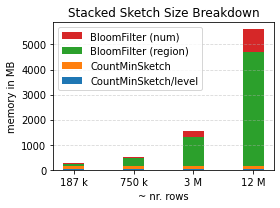

In [94]:
fig, ax = plt.subplots(figsize=(4, 3))
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(n_elements)
handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

## Sketch Size